In [1]:
import glob
import sys
import subprocess

sys.path.append("/u/lukas.rilling/dev/")

from returnn_training_progress import get_epoch_data
from returnn_training_plot_nb import plot_df
%load_ext autoreload
%autoreload 2

In [2]:
base_dir = "/u/lukas.rilling/experiments/glow_tts_asr_v2/output/"
wer_subdir = "tts_eval_gl/test-clean/swer/ls960eow_phon_ctc_50eps_fastsearch/sclite/wer"
wer_files = str(
    subprocess.check_output(
        f"find {base_dir} -type l -name 'wer' -path '*swer*' -not -path '*eval_reference*'",
        shell=True,
    ),
    "utf-8",
).split("\n")[:-1]

wer_files

['/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/conformer_coupling/raw_audio/no_ddi/glowTTS_100ep_pe1/tts_eval_gl/test-clean/swer/ls960eow_phon_ctc_50eps_fastsearch/sclite/wer',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/conformer_coupling/raw_audio/no_ddi/glowTTS_ASR_conformer_two_forward_pass/tts_eval_gl/test-clean/swer/ls960eow_phon_ctc_50eps_fastsearch/sclite/wer',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/conformer_coupling/raw_audio/no_ddi/glowTTS_ASR_conformer_x_vector_v2/tts_eval_gl/test-clean/swer/ls960eow_phon_ctc_50eps_fastsearch/sclite/wer',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/joint_training/conformer_coupling/raw_audio/ddi/glowTTS_100ep_pe1_radam1e-9/tts_eval_gl/test-clean/swer/ls960eow_phon_ctc_50eps_fastsearch/sclite/wer',
 '/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiment

In [3]:
from returnn.config import Config as ReturnnConfig

returnn_configs = [ReturnnConfig() for _ in wer_files]

for r, f in zip(returnn_configs, wer_files):
    r.load_file(
        f.replace("output", "alias").replace(
            wer_subdir,
            "/training/output/returnn.config",
        )
    )
returnn_configs[0].value("num_epochs", "default")

'100'

In [4]:
import numpy as np
import os

wer_files_first_index = []
experiment_group = []
wers = []
nisqas = []
nisqa_confidence =[]
encoder_channels = []
num_epochs = []
dec_dropout = []
mean_only = []
lr = []
optimizer = []
grad_clip = []
for i,f in enumerate(wer_files):
    with open(f, "r") as ff:
        wers.append(float(ff.readline().replace("\n", "")))

    mos_path = f.replace(wer_subdir, "tts_eval_gl/test-clean/nisqa_mos/average")
    if os.path.exists(mos_path):
        with open(mos_path, "r") as fmos:
            nisqas.append(float(fmos.readline().replace("\n", "")))
    else:
        nisqas.append(None)

    mos_conf_path = f.replace(wer_subdir, "tts_eval_gl/test-clean/nisqa_mos/confidence_max_interval")
    if os.path.exists(mos_conf_path):
        with open(mos_conf_path, "r") as fmos:
            nisqa_confidence.append(float(fmos.readline().replace("\n", "")))
    else:
        nisqa_confidence.append(None)

    folders = ["librispeech_glow_asr", "joint_training/default", "joint_training/conformer_coupling", "joint_training/given_alignments", "tts_architecture"]
    found = False
    for folder in folders:
        if folder in f:
            experiment_group.append(folder)
            found = True
            break
    assert len(wers) == len(experiment_group), f"Can't find this experiment group: {f}"

    num_epochs.append(int(returnn_configs[i].value("num_epochs", "-")))

    if returnn_configs[i].has("model_kwargs"):
        model_kwargs = eval(returnn_configs[i].value("model_kwargs", "default"))

        if "model_config" in model_kwargs:
            model_config = model_kwargs["model_config"]

            if "decoder_config" in model_config:
                dec_dropout.append(model_config["decoder_config"]["p_dropout"])
            else: 
                dec_dropout.append("-")

            if "text_encoder_config" in model_config:
                if "filter_channels" in model_config["text_encoder_config"]:
                    encoder_channels.append(model_config["text_encoder_config"]["filter_channels"])
                else: 
                    encoder_channels.append("-")
                mean_only.append(model_config["text_encoder_config"]["mean_only"])
            else:
                encoder_channels.append("-")
                mean_only.append("-")
        else:
            if "tts_architecture" in f:
                dec_dropout.append(0.0)
                if "filter_channels" in model_kwargs:
                    encoder_channels.append(model_kwargs["filter_channels"])
                else:
                    encoder_channels.append("-")

                if "mean_only" in model_kwargs:
                    mean_only.append(model_kwargs["mean_only"])
                else:
                    mean_only.append("-")

            else:
                dec_dropout.append("-")

    if returnn_configs[i].has("learning_rates"):
        learning_rates = np.array(eval(returnn_configs[i].value("learning_rates", "default")))
        lr_argmax = learning_rates.argmax()
        lr.append(
            f"[0: {learning_rates[0]}, {lr_argmax}: {learning_rates[lr_argmax]}, {lr_argmax + 1}: {learning_rates[lr_argmax + 1]}, {returnn_configs[i].value('num_epochs', None)}: {learning_rates[-1]}]"
        )
    elif returnn_configs[i].has("learning_rate"):
        lr.append(returnn_configs[i].value("learning_rate", None))
    else:
        lr.append("-")

    optimizer.append(returnn_configs[i].value("optimizer", None))

    grad_clip.append(returnn_configs[i].value("gradient_clip_norm", None))

    # possible_splitter = ["search_params", "lm_tuning", "tuning", "tuned"]
    # splitter = ""
    # for s in possible_splitter:
    #     if s in f:
    #         splitter = s
    #         break
    # if splitter == "":
    #     wer_files_first_index.append(f.replace("default_250/dev-other/sclite/wer", "").replace("search/dev-other/sclite/wer", ""))
    #     continue
    # wer_files_first_index.append(f[:f.index(splitter)])
assert len(wers) == len(experiment_group), f"Well wer has length: {len(wers)} and experiment_group has length {len(experiment_group)}"
len(wers), len(nisqas), len(num_epochs), len(dec_dropout), len(mean_only), len(encoder_channels), len(lr), len(optimizer)

(91, 91, 91, 91, 91, 91, 91, 91)

In [16]:
import pandas as pd

index = pd.MultiIndex.from_arrays([experiment_group, wer_files], names=("Group", "Experiment"))

df = pd.DataFrame({"sWER": wers, "autoMOS": nisqas, "autoMOS confidence": nisqa_confidence, "num_epochs": num_epochs, "decoder dropout": dec_dropout, "mean only": mean_only, "encoder channels": encoder_channels, "LR": lr, "Optimizer": optimizer}, index=index)

df

sWER  \
Group                             Experiment                                                  
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   12.4   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   20.9   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...    5.2   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   14.7   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   14.4   
...                                                                                     ...   
tts_architecture                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   20.9   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   95.4   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   25.2   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   25.9   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  105.6   

                                                                                       autoMOS  \
Group                             Experiment                                                     
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.936271   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.449569   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.136262   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.588368   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.718031   
...                                                                                        ...   
tts_architecture                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  3.312732   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.633865   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  3.463099   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  3.391651   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  3.165388   

                                                                                      autoMOS confidence  \
Group                             Experiment                                                               
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
...                                                                                                  ...   
tts_architecture                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   

                                                                                      num_epochs  \
Group                             Experiment                           

In [17]:
mle_scores = []
mle_dev_scores = []
mle_devtrain_scores = []
dp_scores = []
dp_dev_scores = []
dp_devtrain_scores = []
finished = []
joint = []
for index, series in df.iterrows():
    data = get_epoch_data(index[1].replace(wer_subdir, "training/work/learning_rates").replace("output", "alias"), None)
    if (
        data is None
        or "mle" not in data[list(data.keys())[-1]]["error"]
        or "dp" not in data[list(data.keys())[-1]]["error"]
    ):
        finished.append(False)
        mle_scores.append(False)
        mle_dev_scores.append(False)
        dp_scores.append(False)
        dp_dev_scores.append(False)
    else:
        last_epoch_data = data[list(data.keys())[-1]]
        finished.append(True)
        mle_scores.append(last_epoch_data["error"]["mle"])
        dp_scores.append(last_epoch_data["error"]["dp"])
        if "dev_loss_mle" in last_epoch_data["error"]:
            mle_dev_scores.append(last_epoch_data["error"]["dev_loss_mle"])
            dp_dev_scores.append(last_epoch_data["error"]["dev_loss_dp"])
        else:
            mle_dev_scores.append(None)
            dp_dev_scores.append(None)

        if "devtrain_loss_mle" in last_epoch_data["error"]:
            mle_devtrain_scores.append(last_epoch_data["error"]["devtrain_loss_mle"])
            dp_devtrain_scores.append(last_epoch_data["error"]["devtrain_loss_dp"])
        else:
            mle_devtrain_scores.append(None)
            dp_devtrain_scores.append(None)

        joint.append("ce" in last_epoch_data["error"] or "ctc" in last_epoch_data["error"])
        

df["MLE"] = mle_scores
df["dev MLE"] = mle_dev_scores
df["devtrain MLE"] = mle_devtrain_scores
df["DP loss"] = dp_scores
df["DP dev loss"] = dp_dev_scores
df["DP devtrain loss"] = dp_devtrain_scores
df["Joint"] = joint

df.head(5)

sWER  \
Group                             Experiment                                                 
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  12.4   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  20.9   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   5.2   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  14.7   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  14.4   

                                                                                       autoMOS  \
Group                             Experiment                                                     
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.936271   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.449569   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.136262   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.588368   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  2.718031   

                                                                                      autoMOS confidence  \
Group                             Experiment                                                               
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...                 NaN   

                                                                                      num_epochs  \
Group                             Experiment                                                       
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         100   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         250   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         250   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         100   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         100   

                                                                                      decoder dropout  \
Group                             Experiment                                                            
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.05   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.05   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.05   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.05   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.05   

                                                                                     mean only  \
Group                             Experiment                                                     
joint_training/conformer_coupling /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...     False   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...     False   
                                  /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...     False   
                                  /u/lukas.rilling/exper

In [18]:
df_no_index = df.reset_index().round(decimals=2)
df_no_index["Experiment"] = df_no_index["Experiment"].str.replace("tts_eval_gl/test-clean/swer/ls960eow_phon_ctc_50eps_fastsearch/sclite/wer", "")
df_no_index["Experiment"] = df_no_index["Experiment"].str.replace("/u/lukas.rilling/experiments/glow_tts_asr_v2/output/experiments/librispeech/", "")
columns = ["Group", "encoder channels", "num_epochs", "decoder dropout", "mean only", "LR", "Optimizer", "MLE", "dev MLE", "devtrain MLE", "DP loss", "DP dev loss", "DP devtrain loss", "sWER", "autoMOS", "Experiment"]

In [19]:
print(df_no_index[~df_no_index["Joint"]].to_markdown())

|    | Group                             | Experiment                                                                                                              |   sWER |   autoMOS |   autoMOS confidence |   num_epochs |   decoder dropout | mean only   | encoder channels   | LR                                               | Optimizer                            |   MLE |   dev MLE |   devtrain MLE |   DP loss |   DP dev loss |   DP devtrain loss | Joint   |
|---:|:----------------------------------|:------------------------------------------------------------------------------------------------------------------------|-------:|----------:|---------------------:|-------------:|------------------:|:------------|:-------------------|:-------------------------------------------------|:-------------------------------------|------:|----------:|---------------:|----------:|--------------:|-------------------:|:--------|
|  0 | joint_training/conformer_coupling | joint_training/conformer_co

In [26]:
print(df_no_index[df_no_index["Joint"]].to_markdown())


|    | Group                             | Experiment                                                                                                                                          |   sWER |   autoMOS |   autoMOS confidence |   num_epochs |   decoder dropout | mean only   |   encoder channels | LR                                               | Optimizer                            |   MLE |   dev MLE |   devtrain MLE |   DP loss |   DP dev loss |   DP devtrain loss | Joint   |
|---:|:----------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------|-------:|----------:|---------------------:|-------------:|------------------:|:------------|-------------------:|:-------------------------------------------------|:-------------------------------------|------:|----------:|---------------:|----------:|--------------:|-------------------:|:--------|
|  1 | joint_t

<Axes: xlabel='autoMOS', ylabel='sWER'>

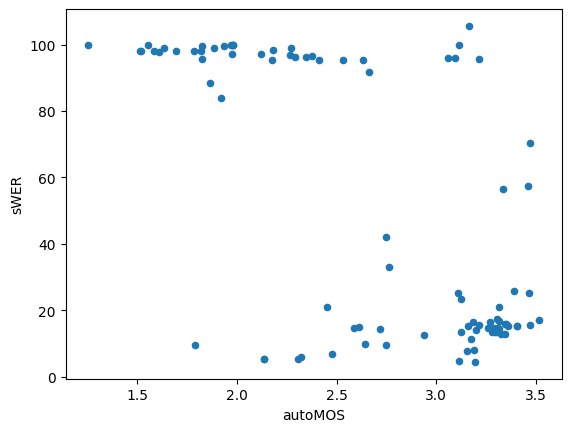

In [20]:
df.plot(kind="scatter", x="autoMOS", y="sWER")

<Axes: xlabel='sWER', ylabel='dev MLE'>

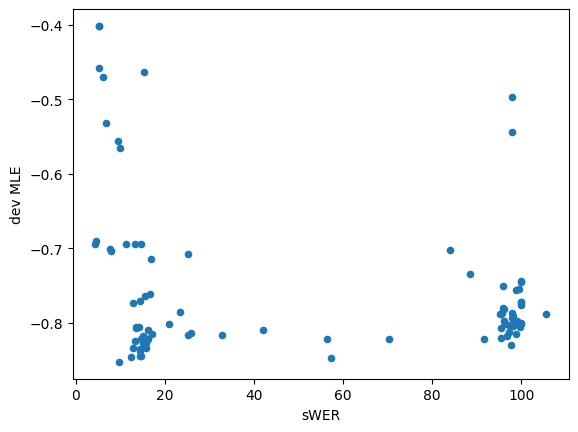

In [21]:
df.plot(kind="scatter", x="sWER", y="dev MLE")

<Axes: xlabel='autoMOS', ylabel='dev MLE'>

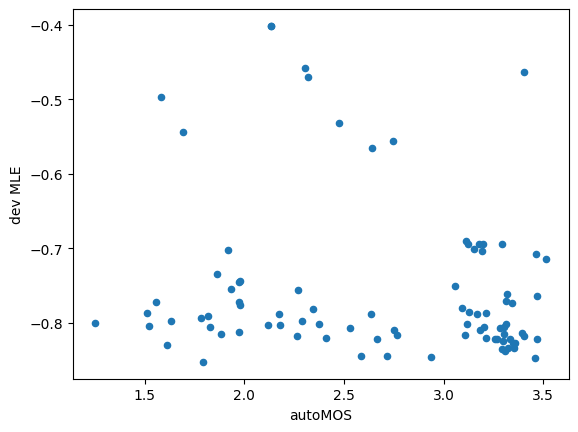

In [22]:
df.plot(kind="scatter", x="autoMOS", y="dev MLE")

<Axes: xlabel='sWER', ylabel='DP dev loss'>

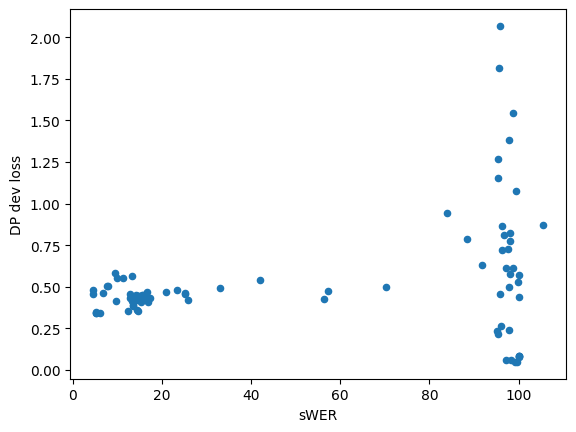

In [23]:
df.plot(kind="scatter", x="sWER", y="DP dev loss")

<Axes: xlabel='sWER', ylabel='DP loss'>

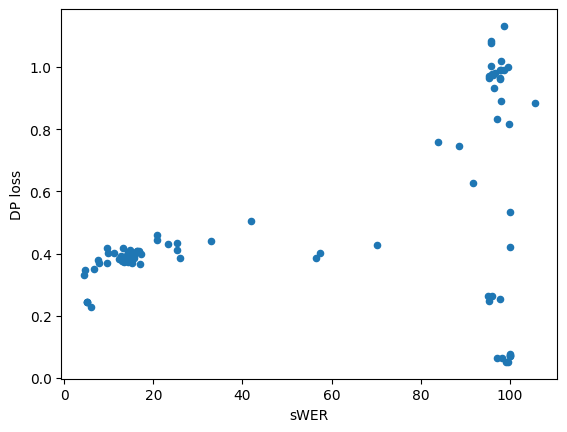

In [24]:
df.plot(kind="scatter", x="sWER", y="DP loss")

In [25]:
df_standard_flow_variations = df[~df["Joint"]].replace("-", np.nan)
df_standard_flow_variations[~df_standard_flow_variations["Experiment"].str.contains("simple_encoder") & ~df_standard_flow_variations["Experiment"].str.contains("ddi_actnorm")]


KeyError: 'Experiment'

In [ ]:
df_no_given_alignment[(df_no_given_alignment["DP loss"] < 0.6) & (df_no_given_alignment["sWER"] > 30)]

sWER  \
Group                           Experiment                                                  
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  100.0   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   70.3   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   57.3   
tts_architecture                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  100.0   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...   56.4   

                                                                                     autoMOS  \
Group                           Experiment                                                     
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  1.253899   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  3.469843   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  3.459152   
tts_architecture                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  3.115826   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...  3.333580   

                                                                                    num_epochs  \
Group                           Experiment                                                       
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         200   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         200   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         200   
tts_architecture                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         100   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...         100   

                                                                                    decoder dropout  \
Group                           Experiment                                                            
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.05   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.05   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.05   
tts_architecture                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.00   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             0.00   

                                                                                   mean only  \
Group                           Experiment                                                     
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...     False   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...     False   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...     False   
tts_architecture                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...     False   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...       NaN   

                                                                                    encoder channels  \
Group                           Experiment                                                             
joint_training/given_alignments /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             768.0   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...               NaN   
                                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...               NaN   
tts_architecture                /u/lukas.rilling/experiments/glow_tts_asr_v2/ou...             192.0   
                                /u/lukas.rilling/exper

<Axes: xlabel='sWER', ylabel='DP loss'>

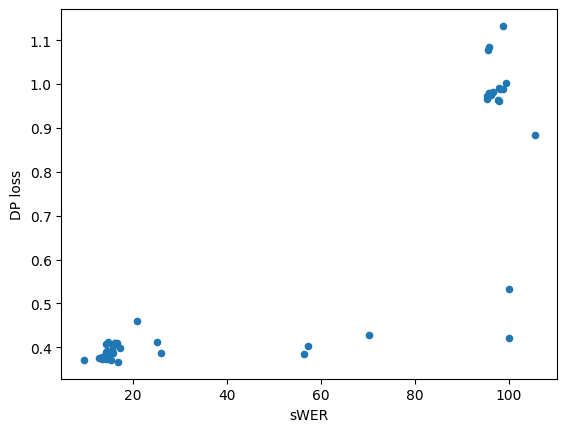

In [ ]:
df_standard_flow_variations.plot(kind="scatter", x="sWER", y="DP loss")

<Axes: xlabel='sWER', ylabel='MLE'>

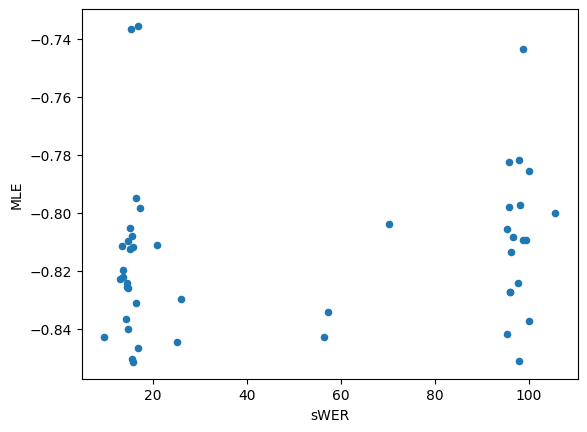

In [ ]:
df_no_given_alignment.plot(kind="scatter", x="sWER", y="MLE")

<Axes: xlabel='autoMOS', ylabel='DP dev loss'>

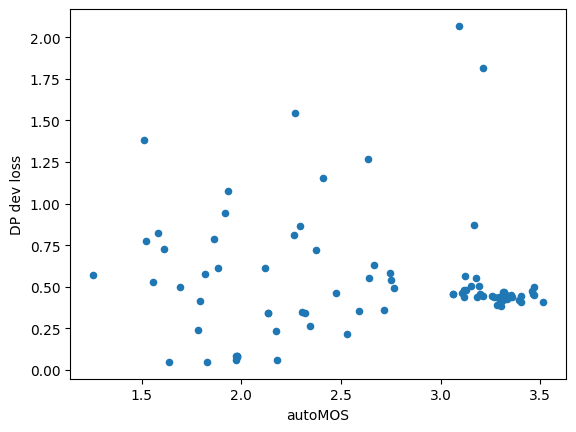

In [ ]:
df.plot(kind="scatter", x="autoMOS", y="DP dev loss")

In [ ]:
score_columns = ["sWER", "autoMOS", "dev MLE", "DP dev loss"]

df_scores = df[score_columns]
df_scores.corr()

,sWER,autoMOS,dev MLE,DP dev loss
sWER,1.000000,-0.638873,-0.254970,0.267750
autoMOS,-0.638873,1.000000,-0.154358,-0.022213
dev MLE,-0.254970,-0.154358,1.000000,-0.048277
DP dev loss,0.267750,-0.022213,-0.048277,1.000000
